In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton
inputData = load_rts96_data(return_as_type=true);

# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);

 12.748469 seconds (10.98 M allocations: 2.658 GB, 2.35% gc time)


In [2]:
n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

In [ ]:
conductor_name = "waxwing"
cp = return_conductor_params(conductor_name)

In [5]:
using PyPlot
PyPlot.svg(true)

true

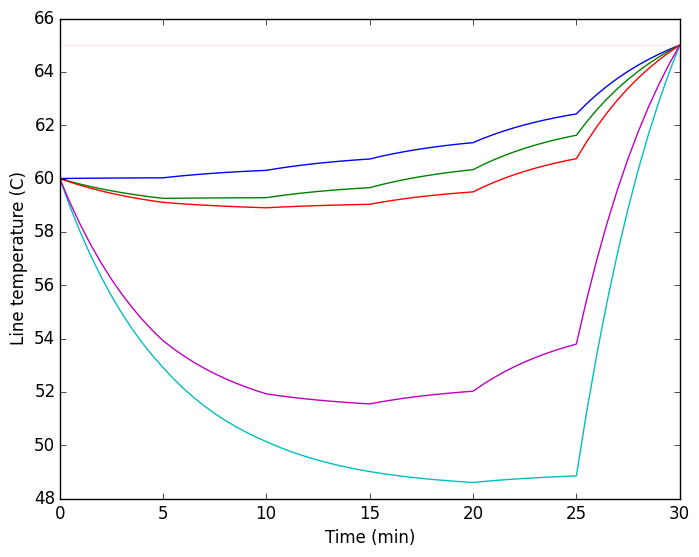

PyObject <matplotlib.text.Text object at 0x7f09de0e72e8>

In [12]:
# plot the first few instanton candidates
numTraces = 5

traj = temperatureTrajectory(inputData,outputData,cp,1)
num_intervals = length(inputData.R0)/length(inputData.k)
xvals = (0:length(traj)-1)*num_intervals*inputData.int_length/(60*(length(traj)-1))

fig = figure()
hold(true)
for i = 1:numTraces
    plot(xvals,temperatureTrajectory(inputData,outputData,cp,i))
end
plot([0,30],[cp.Tlim;cp.Tlim],"r",alpha=0.1)
xlabel("Time (min)")
ylabel("Line temperature (C)")

In [17]:
rand(5,5)

5x5 Array{Float64,2}:
 0.660218   0.110866  0.520787  0.658901   0.253394
 0.789614   0.953053  0.443114  0.384963   0.56339 
 0.0126105  0.766931  0.312439  0.740792   0.99061 
 0.0788136  0.35003   0.181816  0.255758   0.989845
 0.216203   0.808016  0.604927  0.0457221  0.589167

In [21]:
sparse([])

0x1 sparse matrix with 0 Any entries:

In [20]:
Qtemp = sparse(rand(5,5))
blkdiag(Qtemp,Qtemp)

10x10 sparse matrix with 50 Float64 entries:
	[1 ,  1]  =  0.0308924
	[2 ,  1]  =  0.581733
	[3 ,  1]  =  0.472396
	[4 ,  1]  =  0.643401
	[5 ,  1]  =  0.391947
	[1 ,  2]  =  0.272704
	[2 ,  2]  =  0.594932
	[3 ,  2]  =  0.214696
	[4 ,  2]  =  0.0418114
	[5 ,  2]  =  0.0914868
	⋮
	[10,  8]  =  0.641015
	[6 ,  9]  =  0.645041
	[7 ,  9]  =  0.82213
	[8 ,  9]  =  0.965197
	[9 ,  9]  =  0.86935
	[10,  9]  =  0.505984
	[6 , 10]  =  0.610916
	[7 , 10]  =  0.104585
	[8 , 10]  =  0.72247
	[9 , 10]  =  0.788193
	[10, 10]  =  0.32762

Be thoughtful about inputs. What is the bare minimum needed to generate one of these temperature-vs-time plots?

* eventidx
* score
* Ridx?
* n, nr, num_intervals
* conductor name
* lines
* res
* reac
* line_lengths
* Y

What should the method do? Return temperature-vs-time given input data. Don't generate a plot -- that's too opinionated.

I should be able to pass one of the `results` vectors and get temp-vs-time data back out. That would be really nice.

In [27]:
finalTemps = []
for eidx in 1:length(outputData.score)
    push!(finalTemps,instantonTimeSeries(inputData,outputData,eidx)[end])
end

In [29]:
(minimum(finalTemps),maximum(finalTemps))

(64.99953229383019,65.0001314401133)

In [64]:
function temperatureTrajectory(
    i::InstantonInputData,
    o::InstantonOutputData,
    cp::ConductorParams,
    eidx,
    fixed_wind=[];
    )
    
    n = size(i.Y,1)
    nr = length(i.Ridx)
    numSteps = convert(Int64,length(i.G0)/n)

    # Thermal parameters:
    Tmid = (i.Tamb + cp.Tlim)/2
    temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
    therm_a = cp.mCp\(-cp.ηc - 4*cp.ηr*(Tmid + 273)^3) # Fixed wrt power flow
    
    # Line parameters:
    idx = find(o.score.==sort(o.score)[eidx])[1]
    line = i.lines[i.line_lengths.!=0][idx]
    from,to = line
    r_ij = i.res[i.line_lengths.!=0][idx]
    x_ij = i.reac[i.line_lengths.!=0][idx]
    L_ij = i.line_lengths[i.line_lengths.!=0][idx]

    temp_trajectory = Vector()
    angle_dump = Vector()
    diffs_dump = Vector()

    if isempty(fixed_wind)
        fixed_wind = Array(FloatingPoint,0)
        for t in 1:numSteps
            append!(fixed_wind,o.x[idx][t])
        end
    end

    fixed_A = fixed_wind_A(numSteps,i.Y,i.ref,i.k)
    fixed_P = expand_renewable_vector(fixed_wind,i.Ridx,n,numSteps)
    fixed_b = fixed_wind_b(n,numSteps,i.G0,i.R0+fixed_P,i.D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,n,numSteps)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    temp_values = [i.T0]
    power_flow = Float64[]

    T0 = i.T0
    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*i.Sb/(3*L_ij) # W/m
        push!(power_flow,(i.Sb/1e6)*θij/x_ij)
        therm_b = cp.mCp\( f_loss_si + cp.ηc*i.Tamb - cp.ηr*((Tmid + 273)^4 - 
            (i.Tamb+273)^4) + 4*cp.ηr*Tmid*(Tmid + 273)^3 + cp.qs )
            temp_values = [temp_values;temp_eq(i.time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end
    return temp_values
end

instantonTimeSeries (generic function with 4 methods)

This is getting really messy. There must be a better way.

Why not process the data I load initially into a set of objects -- line objects, bus objects, etc? Then I could pass the objects into the method and refer to their properties rather than passing each individual property value. 

What do I really want? I want to take system information, bus injections, and line parameters and return line temperature data. This shouldn't be hard.

In [65]:
# Choose event index (1 is instanton):
eidx = 1
idx = find(outputData.score.==sort(outputData.score)[eidx])[1]

from,to = inputData.lines[idx]

conductor_name = "waxwing"
cp = return_conductor_params(conductor_name)

num_intervals = 6

# Generate this many random vectors:
numVecs = 10
vecs = Array(Vector,0)

# First vector is instanton analysis output:
tempVec = Array(FloatingPoint,0)
for i in 1:num_intervals
    append!(tempVec,outputData.x[idx][i])
end
push!(vecs,tempVec)

# Second vector represents accurate forecast:
push!(vecs,zeros(length(vecs[1])))

# Third vector cancels all wind gen:
push!(vecs,-inputData.R0[find(inputData.R0)])

# Add a family of vectors with same norm as
# instanton vector:
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(nr*num_intervals) - 0.5).*(i+1)/35
    # Normalize to match min-score objective:
    traj = sqrt(outputData.score[idx])*inter/norm(inter)
    push!(vecs,traj)
end

In [66]:
# Use power flow data and thermal model to compute
# temperature trajectories for each vector:
temp_trajectories = Array(Vector,0)
for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    temp_values = temperatureTrajectory(inputData,outputData,cp,eidx,fixed_wind)    
    push!(temp_trajectories,temp_values)
end

In [55]:
# Plotting:
using Interact
using PyPlot
PyPlot.svg(true)

true

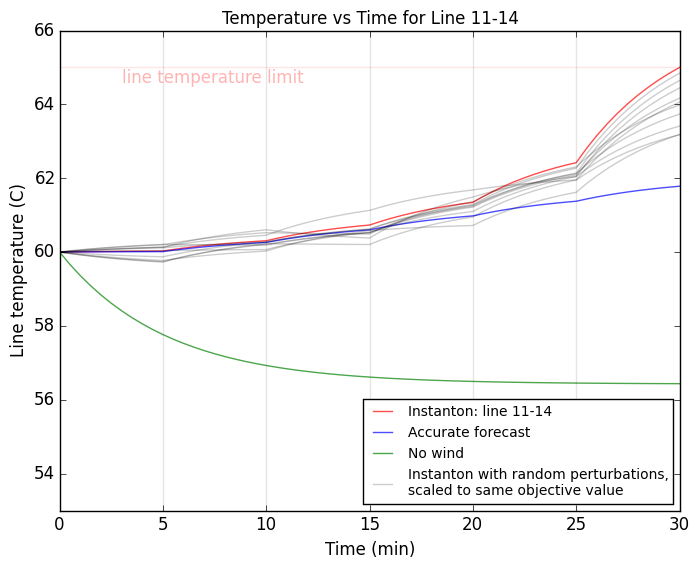

PyObject <matplotlib.text.Text object at 0x7f22ec705d30>

In [67]:
# Plot
fig = figure(figsize=(8,6))

xvals = (0:length(temp_trajectories[1])-1)*num_intervals*inputData.int_length/(60*(length(temp_trajectories[1])-1))
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(xvals,temp_trajectories[i],alpha=0.7,"r")
        elseif i == 2
        plot(xvals,temp_trajectories[i],alpha=0.7,"b")
        elseif i == 3
        plot(xvals,temp_trajectories[i],alpha=0.7,"g")
    else
        plot(xvals,temp_trajectories[i],alpha=0.2,"k")
    end
end
title("Temperature vs Time for Line $(from)-$(to)",fontsize=12)
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)",
    "Accurate forecast",    
    "No wind",
    "Instanton with random perturbations, \nscaled to same objective value"],fontsize=10,loc=4)
axis([0,30,53,66])
for i in 1:num_intervals
    xval = i*inputData.int_length/60
    plot([xval;xval],[40,1.1*cp.Tlim],"k",alpha=0.1)
end
plot([0,30],[cp.Tlim;cp.Tlim],"r",alpha=0.1)
text(3,64.6,"line temperature limit",color="red",alpha=0.3)#color="#FFB2B2")

#savefig("../images/2015-06-24-trajectory_compare3.png", dpi=600)